In [32]:
import pandas as pd
import os
import random

In [49]:
rev=[]
pred=[]
for file in os.listdir("Downloads/neg/"):
    try:
        data=open("Downloads/neg/"+file)
        rev.append(data.read())
        pred.append(0)
    except UnicodeDecodeError:
        pass
for file in os.listdir("Downloads/pos/"):
    try:
        data=open("Downloads/pos/"+file)
        rev.append(data.read())
        pred.append(1)
    except UnicodeDecodeError:
        pass

In [63]:
random.seed(69)
mapIndexPosition = list(zip(rev,pred))
random.shuffle(mapIndexPosition)
rev,pred = zip(*mapIndexPosition)

In [64]:
data1=pd.DataFrame()
data1["reviews"]=rev
data1["prediction"]=pred

In [67]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count=CountVectorizer()
docs=data1["reviews"].iloc[:2000]
bag=count.fit_transform(docs)
#print(count.vocabulary_)
feature=bag.toarray()

In [71]:
d1=pd.DataFrame(feature)

In [80]:
data1["reviews"].iloc[:1000]

0      A long overdue concert release, Rush-in-Rio DV...
1      Just plain good old stupid. <br /><br />I mean...
2      I've read the comments on Las Vegas and do agr...
3      I first saw this film accidentally when they s...
4      "Babette's Feast" and "The Horse's Mouth" are ...
                             ...                        
995    An absorbing exploration of virtual reality, a...
996    I caught this Cuban film at at an arthouse fil...
997    Full House is one of the worst TV series ever!...
998    Following is an intriguing thriller that requi...
999    I thought the movie was OK but very disappoint...
Name: reviews, Length: 1000, dtype: object

In [79]:
data1.head()

,reviews,prediction
0,"A long overdue concert release, Rush-in-Rio DV...",1
1,Just plain good old stupid. <br /><br />I mean...,0
2,I've read the comments on Las Vegas and do agr...,1
3,I first saw this film accidentally when they s...,1
4,"""Babette's Feast"" and ""The Horse's Mouth"" are ...",1


In [84]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf=TfidfTransformer(use_idf=True,smooth_idf=True)
d2=tfidf.fit_transform(count.fit_transform(docs)).toarray()

In [87]:
d2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [89]:
import re
def preprocessor(text):
    text=re.sub("<[^>]*>","",text)
    emoticons=re.findall("(?::|;|=)(?:-)?(?:\)|\(|D|P)",text)
    text=re.sub("[\W]+"," ",text.lower())+\
                " ".join(emoticons).replace("-","")
    return text

In [91]:
preprocessor(data1.loc[0,"reviews"][-50:])
preprocessor("</a>This :) is a :( test :-)!")
data1["reviews"]=data1["reviews"].apply(preprocessor)

In [93]:
from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
    return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [94]:
tokenizer("runners like running and ths they run")

['runners', 'like', 'running', 'and', 'ths', 'they', 'run']

In [95]:
tokenizer_porter("runners like running and ths they run")

['runner', 'like', 'run', 'and', 'th', 'they', 'run']

In [105]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [113]:
from nltk.corpus import stopwords

stop=stopwords.words("english")
[w for w in tokenizer_porter("a running like running and runs a lot")[-10:] if w not in stop]

['run', 'like', 'run', 'run', 'lot']

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm="l2",smooth_idf=True)
y=data1.iloc[:1000]["prediction"]
x=tfidf.fit_transform(data1.iloc[:1000].reviews)

In [123]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.5,shuffle=False)

In [124]:
import pickle 
from sklearn.linear_model import LogisticRegressionCV
clf=LogisticRegressionCV(cv=5,scoring="accuracy",random_state=0,n_jobs=-1,verbose=3,max_iter=300).fit(x_train,y_train)
saved_model=open("saved_model.sav","wb")
pickle.dump(clf,saved_model)
saved_model.close()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


In [125]:
filename="saved_model.sav"
saved_clf=pickle.load(open(filename,"rb"))

In [126]:
saved_clf.score(x_test,y_test)

0.792

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

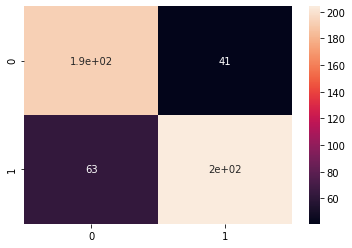

In [131]:
cm=confusion_matrix(saved_clf.predict(x_test),y_test)
sns.heatmap(cm,annot=True)